# Primeira etapa - Simulações numéricas essenciais.

In [1]:
import math
from cmath import *
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt

## Constantes

In [35]:
R1 = 0.3886
R2 = 0.4908
L1 = 0.1378e-3
L2 = 0.1371e-3
C1 = C2 = 0.1e-6
k = 0.1
RC = 100
UF = 15

## Cálculos e simulações

In [36]:
m = k * math.sqrt(L1 * L2)
w = 1 / (math.sqrt(L1 * C1))
f_res = w / (2 * pi)
f_res

42874.14998127845

In [37]:
def CalcularTransformador(Uf, Rc, w, k):
    m = k * math.sqrt(L1 * L2)
    XL1 = w * L1 * 1j
    XC1 = 1/(w * C1 * 1j)
    XM = m * w * 1j
    XL2 = w * L2 * 1j
    XC2 = 1 / (w * C2 * 1j)
    Zrc_c2 = (Rc * XC2) / (Rc + XC2)
    Z = np.array([[R1 + XL1 + XC1, -XM], [-XM, XL2 + R2 + Zrc_c2]])
    V = np.array([Uf, 0])
    i = np.dot(linalg.inv(Z), V)
    return i[0], i[1]

Freq onde o I1 e max: 43082.0


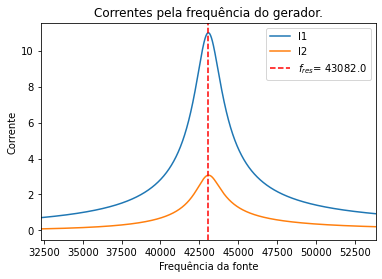

In [38]:
i1_list = []
i2_list = []
freqs = np.linspace(1, 150_000, 150_000)
k = 0.1
for freq in freqs:
    w = 2 * pi * freq
    i1, i2 = CalcularTransformador(UF, RC, w, k)
    i1_list.append(i1)
    i2_list.append(i2)

index_imax = i1_list.index(max(i1_list))
f_res = freqs[index_imax]
print(f"Freq onde o I1 e max: {f_res}")

ponto_ressonancia = (f_res, max(np.abs(i1_list)))

plt.plot(freqs, np.abs(i1_list), label='I1')
plt.plot(freqs, np.abs(i2_list), label='I2')
plt.axvline(f_res, color='red', linestyle='dashed', label=f'$f_{{res}}$= {f_res:.1f}')
plt.title("Correntes pela frequência do gerador.")
plt.xlabel('Frequência da fonte')
plt.ylabel("Corrente")
plt.legend()
plt.xlim(f_res - 0.25 * f_res, f_res + 0.25 * f_res)
plt.show()

Potencia maxima no secundario: 56.671362865704765


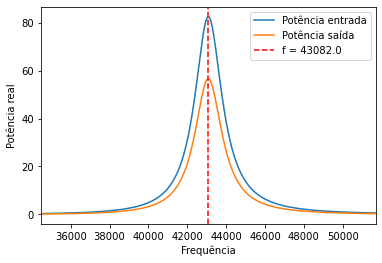

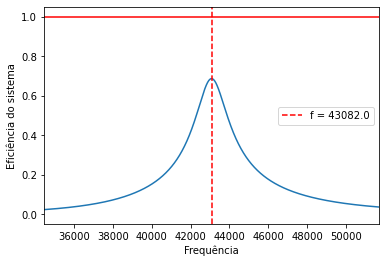

In [43]:
p_1 = []
p_2 = []

for i, freq in enumerate(freqs):
    p_1.append((UF * i1_list[i].conjugate()) / 2)
    z_c2 = 1 / (freq * 2 * pi * C2 * 1j)
    z_rcc2 = (z_c2 * RC) / (z_c2 + RC)
    u_rcc2 = z_rcc2 * i2_list[i]
    i_rc = u_rcc2 / RC 
    p_2.append((RC * i_rc * i_rc.conjugate()) / 2)

eficiencia = [np.abs(p_2[i]) / np.abs(p_1[i]) for i in range(0, len(p_1))]
f = freqs[p_1.index(max(p_1))]
print(f"Potencia maxima no secundario: {np.abs(max(p_2))}")

plt.plot(freqs, np.real(p_1), label='Potência entrada')
plt.plot(freqs, np.real(p_2), label='Potência saída')
plt.axvline(f, color='red', linestyle='dashed', label=f'f = {f:.1f}')
plt.xlabel("Frequência")
plt.ylabel("Potência real")
plt.xlim(f - 0.2*f, f + 0.2*f)
plt.legend()
plt.show()

plt.plot(freqs, np.real(eficiencia))
plt.axvline(f, color='red', linestyle='dashed', label=f'f = {f:.1f}')
plt.axhline(y=1, color='r', linestyle='-')
plt.legend()
plt.xlabel("Frequência")
plt.ylabel("Eficiência do sistema")
plt.xlim(f - 0.2*f, f + 0.2*f)
plt.show()

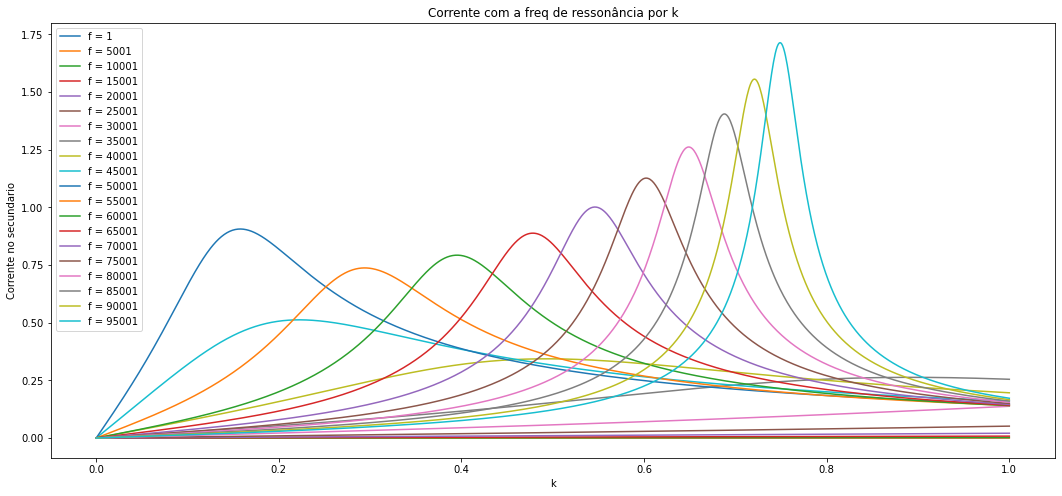

In [34]:
fig = plt.figure(figsize=(18, 8))
k_space = np.linspace(0, 1, 1000)
for f in range(1, 100_000, 5_000):
    i_2 = []
    for k in k_space:
        w = 2 * pi * f
        i1, i2 = CalcularTransformador(UF, RC, w, k)

        i_2.append(i2)
    plt.plot(k_space, np.abs(i_2), label=f"f = {f}")

plt.title("Corrente com a freq de ressonância por k")
plt.xlabel("k")
plt.ylabel("Corrente no secundario")
plt.legend(loc='upper left')
plt.show()

## Etapa de escolha do indutor + capacitor para o circuito.
Metodologia: 
- Fixar um dos dois: C ou F.
- Escolher uma frequência de ressonância.
- Calcular o F/C mais adequado (Minimizar a reatância).   

Selecionar um dos capacitores disponíveis (listados abaixo):
- $0.1 \mu F$
- $150 nF$
- $1 \mu F$
- $4.7 \mu F$
- $0.47 \mu F$   
Escolhido o capacitor, calcular a indutância da bobina que minimiza a reatância com a eq:
$$L\cdot \omega \cdot j = \dfrac{j}{\omega \cdot C}$$    
Com esse valor calculado, pode-se usar o site [Physika](https://physika.info/site/aplicativos/javascript/inkalc.htm) para obter os parâmetros construtivos da bobina.



In [23]:
w_fixado = 50_000.32 * 2 * np.pi
C_escolhido = 0.1e-6
L_calculado = 1 / (w_fixado ** 2 * C_escolhido)
L_calculado * 1000 # Em mH

0.10131988674363739

In [1]:
# Tentativa de fazer um algoritmo de otimizacao do L e do w
i2_list = []
l_list = []
f_list = []
C_escolhido = 0.1e-6

for f in freqs:
    w = f * 2 * np.pi
    L1 = L2 = 1 / (w ** 2 * C_escolhido)
    I1, I2 = CalcularTransformador(UF, RC, w, k)
    if L1 < 5e-3 and L1 > 0.1e-3:
        i2_list.append(I2)
        l_list.append(L1)
        f_list.append(f)

i = i2_list.index(max(i2_list))
l1_maximiza = l_list[i]
w_maximiza = f_list[i]
print(f"L1 otimizado: {l1_maximiza * 1000}\n w otimizado: {w_maximiza}")

NameError: name 'freqs' is not defined

## Atualizando o modelo para onda quadrada
$$V1(t) = \dfrac{2}{\pi} \cdot V_p \cdot cos(wt)$$

In [48]:
def CalcularTransformador(Uf, Rc, w, k):
    m = k * math.sqrt(L1 * L2)
    XL1 = w * L1 * 1j
    XC1 = 1/(w * C1 * 1j)
    XM = m * w * 1j
    XL2 = w * L2 * 1j
    XC2 = 1 / (w * C2 * 1j)
    Zrc_c2 = (Rc * XC2) / (Rc + XC2)
    ufq = (2 / np.pi) * Uf
    Z = np.array([[R1 + XL1 + XC1, -XM], [-XM, XL2 + R2 + Zrc_c2]])
    V = np.array([ufq, 0])
    i = np.dot(linalg.inv(Z), V)
    return i[0], i[1]

Freq onde o I1 e max: 43082.0


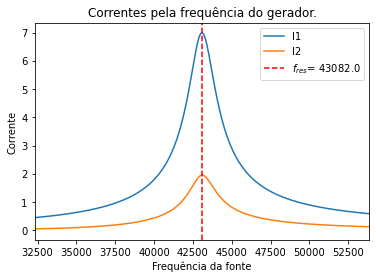

In [53]:
i1_list = []
i2_list = []
for freq in freqs:
    w = 2 * pi * freq
    i1, i2 = CalcularTransformador(UF, RC, w, k)
    i1_list.append(i1)
    i2_list.append(i2)

index_imax = i1_list.index(max(i1_list))
f_res = freqs[index_imax]
print(f"Freq onde o I1 e max: {f_res}")

plt.plot(freqs, np.abs(i1_list), label='I1')
plt.plot(freqs, np.abs(i2_list), label='I2')
plt.axvline(f_res, color='red', linestyle='dashed', label=f'$f_{{res}}$= {f_res:.1f}')
plt.title("Correntes pela frequência do gerador.")
plt.xlabel('Frequência da fonte')
plt.ylabel("Corrente")
plt.legend()
plt.xlim(f_res - 0.25 * f_res, f_res + 0.25 * f_res)
plt.show()

Potencia maxima no secundario: 22.96803825671054


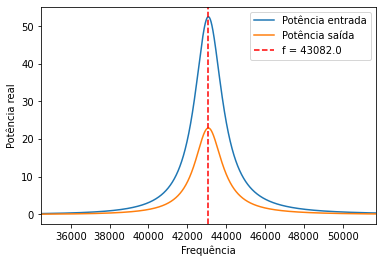

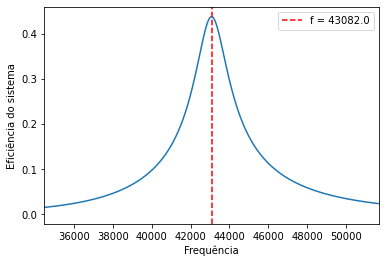

In [54]:
p_1 = []
p_2 = []

for i, freq in enumerate(freqs):
    p_1.append((UF * i1_list[i].conjugate()) / 2)
    z_c2 = 1 / (freq * 2 * pi * C2 * 1j)
    z_rcc2 = (z_c2 * RC) / (z_c2 + RC)
    u_rcc2 = z_rcc2 * i2_list[i]
    i_rc = u_rcc2 / RC 
    p_2.append((RC * i_rc * i_rc.conjugate()) / 2)

eficiencia = [np.abs(p_2[i]) / np.abs(p_1[i]) for i in range(0, len(p_1))]
f = freqs[p_1.index(max(p_1))]
print(f"Potencia maxima no secundario: {np.abs(max(p_2))}")

plt.plot(freqs, np.real(p_1), label='Potência entrada')
plt.plot(freqs, np.real(p_2), label='Potência saída')
plt.axvline(f, color='red', linestyle='dashed', label=f'f = {f:.1f}')
plt.xlabel("Frequência")
plt.ylabel("Potência real")
plt.xlim(f - 0.2*f, f + 0.2*f)
plt.legend()
plt.show()

plt.plot(freqs, np.real(eficiencia))
plt.axvline(f, color='red', linestyle='dashed', label=f'f = {f:.1f}')
plt.legend()
plt.xlabel("Frequência")
plt.ylabel("Eficiência do sistema")
plt.xlim(f - 0.2*f, f + 0.2*f)
plt.show()